<a href="https://colab.research.google.com/github/Rogerio-mack/Machine-Learning-I/blob/main/ML6_CV_GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->


# **6. Validação Cruzada e *GridSearch***
---

Nesta aula você vai aprender:

* O que são os conjuntos de Validação e Teste
* Como e por que aplicar a Validação Cruzada dos modelos
* Como empregar GridSearch do Scikit-Learn para selecionar os hiperparâmetros de um modelo

A avaliação dos diferentes hiperparâmetros dos modelos, como o valor de k no KNeighborsClassifier ou a profundidade da Árvore de Decisão, sobre o conjunto de teste traz o risco de produzirmos um sobreajuste do modelo, pois vamos empregando sempre hiperparâmetros que mais e mais elevam o ajuste do modelo ao conjunto de teste - é como se estivéssemos, de fato, empregando o conjunto de teste para o treinamento. 

> *Uma analogia útil: se medir a acuracidade sobre o conjunto de treinamento é como dar uma prova para um aluno onde haveria somente questões que ele já conheceu em aula (o conjunto de treinamento), o uso do conjunto de teste para ajustar os hiperparâmetros do modelo, seria como dar a nota para o aluno (mas sem indicar as respostas) para que ele fizesse novas tentativas da prova até obter o resultado que desejasse. Em ambos os casos parece ser uma má prática, seja para o aprendizado humano, seja para o aprendizado de máquina.*

Uma técnica comum para resolver isso é o emprego da validação cruzada que, normalmente, é quase um padrão para a seleção e ajuste de modelos e, nesta aula, você vai aprender como empregar a validação cruzada e como aplicar técnicas eficientes para ajuste e seleção de modelos.




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import seaborn as sns

Vamos partir visitando um caso de Classificação em que aplicamos o modelo de K-Vizinhos e estenderemos depois essas técnicas para Àrvores de Decisão e Florestas Aleatórias.

# CASO: Breast Cancer biopsy

Este banco de dados de câncer de mama foi obtido dos Hospitais da Universidade de Wisconsin, que avaliou biópsias de tumores de mama em 699 pacientes até 1992;. Cada um dos nove atributos foi pontuado em uma escala de 1 a 10.

Fonte: https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv

Documentação: https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/biopsy.html

In [ ]:
df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv',index_col=0)
df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,class
1,1000025,5,1,1,1,2,1.0,3,1,1,benign
2,1002945,5,4,4,5,7,10.0,3,2,1,benign
3,1015425,3,1,1,1,2,2.0,3,1,1,benign
4,1016277,6,8,8,1,3,4.0,3,7,1,benign
5,1017023,4,1,1,3,2,1.0,3,1,1,benign


## Preparação dos Dados

As variáveis preditoras são todas numéricas e não há, portanto, necessidade do hot encode dos atributos. Há entretanto valores ausentes.

In [ ]:
df.isnull().sum() / len(df)

ID       0.00000
V1       0.00000
V2       0.00000
V3       0.00000
V4       0.00000
V5       0.00000
V6       0.02289
V7       0.00000
V8       0.00000
V9       0.00000
class    0.00000
dtype: float64

O percentual é pequeno e assim vamos simplesmente excluir os dados ausentes.

In [ ]:
df['V6'] = df[['V6']].fillna(df['V6'].mean())
df.isnull().sum() / len(df)

ID       0.0
V1       0.0
V2       0.0
V3       0.0
V4       0.0
V5       0.0
V6       0.0
V7       0.0
V8       0.0
V9       0.0
class    0.0
dtype: float64

Além disso sendo o Knn um modelo que emprega distância e, portanto, sensível à escala dos dados vamos normalizar os dados aplicando a transformação `MinMaxScaler`. 

## Aplicando o Modelo Knn

Vamos agora implementar o modelo empregando o esquema mais geral de aprendizado supervisionado incluindo o uso dos conjuntos de treinamento e teste, e as avaliações do modelo. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

X = df.drop(columns=['ID','class'])
y = df['class']

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

clf = KNeighborsClassifier(n_neighbors = 9)

clf.fit(X_train, y_train)                 

y_pred = clf.predict(X_test)

print( y_pred[0:10], '...' )
print( clf.score(X_test,y_test) )

['benign' 'benign' 'malignant' 'benign' 'benign' 'malignant' 'benign'
 'benign' 'benign' 'benign'] ...
0.9380952380952381


## Predição de Novos Casos

Se considerarmos 0.93 um bom resultado podemos então aplicar o modelo para novos casos. Por exemplo, podemos fazer predição considerando pacientes hipotéticos valores das medidas v1-v9 dos tumores nos percentis  $[0.10, 0.25, 0.75, 0.90]$. 

In [ ]:
X_new = pd.DataFrame( df.drop(columns=['ID','class']).quantile([0.10, 0.25, 0.75, 0.90]) ).reset_index(drop=True)
display(X_new)
X_new_scaled = scaler.transform(X_new) 

,V1,V2,V3,V4,V5,V6,V7,V8,V9
0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
1,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0
2,6.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,1.0
3,9.0,9.0,8.0,8.0,6.0,10.0,7.0,9.0,3.0


In [ ]:
clf.predict(X_new_scaled)

array(['benign', 'benign', 'malignant', 'malignant'], dtype=object)

In [ ]:
X_new['predicted'] = clf.predict(X_new_scaled)
X_new

,V1,V2,V3,V4,V5,V6,V7,V8,V9,predicted
0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,benign
1,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,benign
2,6.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,1.0,malignant
3,9.0,9.0,8.0,8.0,6.0,10.0,7.0,9.0,3.0,malignant


# Seleção de Hiperparâmetros

No exemplo anterior empregamos o modelo Knn com k=9, uma escolha arbitrária, e a função de distância euclidiana. Será que haveriam *hiperparâmetros* que apresentassem um desempenho melhor? 

A escolha de melhores *hiperparâmetros* é em geral por experimentação uma vez que não existem hiperparâmetros melhores *apriori* para quaisquer conjuntos de dados. A ideia, então, é criarmos os diferentes modelos e avaliarmos o desempenho de cada um para obtermos os melhores hiperparâmetros. 

Podemos então adaptar o nosso código do modelo Knn anterior para, por exemplo, variar os hiperparâmetros k, no range de valores de 2 a 10 e experimentar o resultado das funções distância 'euclidean' e 'manhattan'. manhattan

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv',index_col=0)
df['V6'] = df[['V6']].fillna(df['V6'].mean())

X = df.drop(columns=['ID','class'])
y = df['class']

scaler.fit(X)
X = scaler.transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

for k, d in [(k,d) for k in range(2,11) for d in ['euclidean','manhattan']]:

  clf = neighbors.KNeighborsClassifier(n_neighbors = k, metric= d )

  clf.fit(X_train, y_train)                 

  y_pred = clf.predict(X_test)

  print( k, d, np.round( clf.score(X_test,y_test), 4) )

2 euclidean 0.9095
2 manhattan 0.9286
3 euclidean 0.9429
3 manhattan 0.9381
4 euclidean 0.9381
4 manhattan 0.9333
5 euclidean 0.9429
5 manhattan 0.9333
6 euclidean 0.9381
6 manhattan 0.9286
7 euclidean 0.9429
7 manhattan 0.9333
8 euclidean 0.9381
8 manhattan 0.9333
9 euclidean 0.9381
9 manhattan 0.9381
10 euclidean 0.9381
10 manhattan 0.9429


Embora tendo escolhido os conjuntos de treinamento e teste de forma aleatória o resultado acima, pode depender do par (treinamento, teste) escolhido. 

> *Tire o parâmetro `random_state=123` do código acima e veja que a cada nova execução diferentes valores de acuracidade são produzidos para os mesmos parâmetros. Assim, para obtermos uma medida mais efetiva dos modelos, precisamos executar sobre um grande número de diferentes conjuntos de teste.*

Para não considerarmos o resultado de uma única amostra, podemos fazer várias execuções a obter a média dos valores sobre várias amostras, o que será uma medida independente de um par específico de dados e uma melhor aproximação do resultado esperado do modelo.



In [ ]:
scores_means = {}

for k, d in [(k,d) for k in range(2,9) for d in ['euclidean','manhattan']]:
  
  scores = []
  for i in range(0,25):

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

    clf = KNeighborsClassifier(n_neighbors = k, metric= d )

    clf.fit(X_train, y_train)                 

    y_pred = clf.predict(X_test)
    
    scores.append(clf.score(X_test,y_test))

  scores_means[(k,d)] = np.mean(scores)
  
scores_means = pd.DataFrame(scores_means.values(), index=scores_means.keys()).reset_index()
scores_means.columns = ['k','metric','score']

display(scores_means)
print('\nBest result:\n')
display(scores_means.nlargest(1,'score'))

,k,metric,score
0,2,euclidean,0.909524
1,2,manhattan,0.928571
2,3,euclidean,0.942857
3,3,manhattan,0.938095
4,4,euclidean,0.938095
5,4,manhattan,0.933333
6,5,euclidean,0.942857
7,5,manhattan,0.933333
8,6,euclidean,0.938095
9,6,manhattan,0.928571



Best result:



,k,metric,score
2,3,euclidean,0.942857


Desse modo, concluímos que para o nosso conjunto de dados os melhores resultados com o modelo knn são obtidos com os parâmetros k=3 e a métrica Euclidiana. 

Um procedimento análogo pode  ser aplicado ao Modelo de Árvore de Decisão para escolha de diferentes hiperparâmetros desse modelo, como a profundidade da Árvore e o critério de escolha dos nós raiz.



In [ ]:
from sklearn.tree import DecisionTreeClassifier

scores_means = {}

for max_depth, criterion in [(max_depth, criterion) for max_depth in range(2,6) for criterion in ['gini','entropy']]:
  
  scores = []
  for i in range(0,25):

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

    clf = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)

    clf.fit(X_train, y_train)                 

    y_pred = clf.predict(X_test)
    
    scores.append(clf.score(X_test,y_test))

  scores_means[(max_depth, criterion)] = np.mean(scores)
  
scores_means = pd.DataFrame(scores_means.values(), index=scores_means.keys()).reset_index()
scores_means.columns = ['max_depth', 'criterion' ,'score']

display(scores_means)
print('\nBest result:\n')
display(scores_means.nlargest(1,'score'))

,max_depth,criterion,score
0,2,gini,0.933333
1,2,entropy,0.923810
2,3,gini,0.938476
3,3,entropy,0.923810
4,4,gini,0.923429
5,4,entropy,0.919048
6,5,gini,0.924190
7,5,entropy,0.920381



Best result:



,max_depth,criterion,score
2,3,gini,0.938476


Aqui o melhor modelo de Árvore de Decisão apresenta um score inferior ao do modelo de K-Vizinhos mais Próximos como k=3 e métrica euclidiana e, assim, optaríamos por este último se levarmos somente o critério de acuracidade como o critério de seleção do melhor modelo, e uma alternativa comum é empregarmos o F1, e o procedimento poderia ser o mesmo.

# Conjuntos de Validação e Teste 

Como você pôde ver é algo bastante trabalhoso avaliar hiperparâmetros e diferentes modelos, havendo ainda dezenas de outros modelos cada um com muitos outros parâmetros.

Além disso, como você viu na introdução desta aula, empregar o conjunto de teste para fazer esse ajuste é como dar a nota do aluno para que ele faça uma nova tentativa da prova até que possa ser aprovado! Fazer a seleção de hiperparâmetros e modelos desse modo traz o risco de sobreajuste no conjunto de teste, porque os hiperparâmetros e modelos podem ser ajustados *até que* o estimador tenha o desempenho ideal e, do mesmo modo que antes para o conjunto de treinamento, o conhecimento sobre o conjunto de teste *vaza* para o modelo e as métricas de avaliação e mascaram o desempenho e a capacidade de generalização do modelo. 

Deveríamos assim separar novamente uma outra parte do conjunto de dados, um *conjunto de validação* que seria empregado para validar o modelo durante a seleção dos hiperparâmetros: o treinamento, com diferentes hiperparâmetros,  continua no conjunto de treinamento; em seguida a avaliação é feita no conjunto de validação; após os experimentos sucedidos, a avaliação final pode ser feita no conjunto de teste.

A implementação do nosso modelo seria então algo como:




In [ ]:
scores_means = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

for k, d in [(k,d) for k in range(2,9) for d in ['euclidean','manhattan']]:
  
  scores = []
  for i in range(0,25):

    X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=123)

    clf = neighbors.KNeighborsClassifier(n_neighbors = k, metric= d )

    clf.fit(X_train_val, y_train_val)                 

    y_pred = clf.predict(X_val)
    
    scores.append(clf.score(X_val,y_val))

  scores_means[(k,d)] = np.mean(scores)
  
scores_means = pd.DataFrame(scores_means.values(), index=scores_means.keys()).reset_index()
scores_means.columns = ['k','metric','score']

display(scores_means)
print('\nBest result:\n')
display(scores_means.nlargest(1,'score'))



,k,metric,score
0,2,euclidean,0.928571
1,2,manhattan,0.948980
2,3,euclidean,0.948980
3,3,manhattan,0.948980
4,4,euclidean,0.948980
5,4,manhattan,0.938776
6,5,euclidean,0.959184
7,5,manhattan,0.959184
8,6,euclidean,0.959184
9,6,manhattan,0.959184



Best result:



,k,metric,score
6,5,euclidean,0.959184


E podemos agora verificar o resultado desse melhor modelo no conjunto de teste para a avaliação final.

In [ ]:
k = scores_means.nlargest(1,'score').k.values[0]
metric = scores_means.nlargest(1,'score').metric.values[0]

clf = neighbors.KNeighborsClassifier(n_neighbors = k, metric= metric )
print(clf)
    
clf.fit(X_train, y_train)                 

print("accuracy: %0.3f" % clf.score(X_test,y_test),'\n')

    

KNeighborsClassifier(metric='euclidean')
accuracy: 0.943 



Veja que são um modelo e valores de acuracidade diferentes do que obtivemos antes e, independentemente disso, é um resultado metodologicamente mais correto. Esperaremos, assim, com esse modelo obter um resultado de 0.93 de acuracidade (e não 0.95!) quando aplicado a novos casos. 

Deixo para você verificar o mesmo para o modelo de Árvore de Decisão. De qualquer modo, esses procedimentos são tão necessários e tão empregados que é razoável encontrarmos implementações prontas para realizar essas tarefas de seleção. Para isso, entretanto, é necessário que você conheça antes o que é o esquema de validação cruzada.

# Cross Validation

Ao particionar os dados disponíveis em três conjuntos, reduzimos drasticamente o número de amostras que podem ser usadas para aprender o modelo.

Uma solução para este problema, e também para buscarmos um resultado menos dependente de uma escolha aleatória particular do par (treino, validação), é uma técnica denominada validação cruzada ou cross validation (CV). Um conjunto de teste ainda deve ser apresentado para avaliação final, mas o conjunto de validação não é mais necessário ao empregar o CV. Em sua forma mais simples, denominada *k-fold CV*, o conjunto de treinamento é dividido em k partições aleatórias menores e o treinamento ocorre do seguinte modo:

> Para as $k$ partições:  

> 1. O modelo é treinado empregando-se $k-1$ partições dos dados de treinamento;

> 2. O modelo resultante é validado na parte restante dos dados, isto é, é usado como conjunto de teste para calcular a métrica de desempenho, por exemplo a acuracidade ou a precisão.

A medida de desempenho do CV é, então, a média dos valores calculados para as $k$ medidas. Embora computacionalmente cara, o CV não desperdiça e é um procedimento mais sistemático que garante que todos os dados serão testados pelo modelo em algum momento. 

<br>

<br>

![imagem](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

<small>
<b>
Figura 1. Esquema de Cross-Validation. <br></b>  (Fonte: https://scikit-learn.org)

O `scikit-learn` implementa diferentes tipos de CV que variam basicamente na forma com são selecionadas as partições. O `KFold` e o `StratifiedKFold` são as formas mais comuns e suas partições são exemplificadas abaixo.

In [ ]:
# you can skip this code!

# Código livremente adaptado de: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
#
cmap_data = plt.cm.viridis 
cmap_cv = plt.cm.binary

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    custom_lines = [Line2D([0], [0], color=cmap_cv(0.2), lw=6),
                Line2D([0], [0], color=cmap_cv(0.8), lw=6)]
    ax.legend(custom_lines, ['Train', 'Test'], loc='upper right')

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["", "class"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax



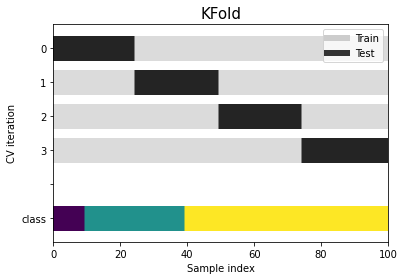

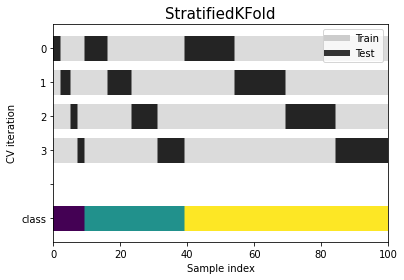

In [ ]:
# you can skip this code!

from sklearn.model_selection import KFold, StratifiedKFold
np.random.seed(1338)

n_splits = 4

n_points = 100
X = np.random.randn(100, 10)

percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

# Evenly spaced groups repeated once
groups = np.hstack([[ii] * 10 for ii in range(10)])

fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)
plt.show()

fig, ax = plt.subplots()
cv = StratifiedKFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)
plt.show()

Note que as faixas correspodem a índices aleatórios e não dados contíguos.

## Aplicando o CV

A forma mais simples de empregar o CV é aplicar a função `cross_val_score()` sobre o estimador e o conjunto de dados. Ela por padrão irá retornar o *score* do estimador em uma estratégia de `StratifiedKFold`, mas outras métricas podem ser obtidas.

In [ ]:
from sklearn.model_selection import cross_val_score

df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv',index_col=0)
df['V6'] = df[['V6']].fillna(df['V6'].mean())

X = df.drop(columns=['ID','class'])
y = df['class']

scaler.fit(X)
X = scaler.transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

clf = neighbors.KNeighborsClassifier(n_neighbors = 3, metric= 'euclidean' )

acc_scores = cross_val_score(clf, X_train, y_train, cv = 10)

print(acc_scores, '\n')
print("accuracy: %0.3f +/- %0.3f" % (acc_scores.mean(), acc_scores.std() * 2),'\n')

for metric in ['accuracy','f1_macro','precision_macro','recall_macro']:
  scores = cross_val_score(clf, X_train, y_train, cv = 4, scoring=metric)
  print(metric + ": %0.3f +/- %0.3f" % (scores.mean(), scores.std() * 2))




[0.97959184 0.93877551 1.         0.97959184 0.95918367 0.95918367
 1.         0.93877551 0.97959184 0.95833333] 

accuracy: 0.969 +/- 0.042 

accuracy: 0.971 +/- 0.008
f1_macro: 0.968 +/- 0.009
precision_macro: 0.970 +/- 0.009
recall_macro: 0.967 +/- 0.018


Aplicando agora o `cross_val_score()` ao nosso exemplo na busca de melhores hiperparâmetros você pode obter:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv',index_col=0)
df['V6'] = df[['V6']].fillna(df['V6'].mean())

X = df.drop(columns=['ID','class'])
y = df['class']

scaler.fit(X)
X = scaler.transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

scores_means = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

for k, d in [(k,d) for k in range(2,9) for d in ['euclidean','manhattan']]:
  
  clf = neighbors.KNeighborsClassifier(n_neighbors = k, metric= d )

  acc_scores = cross_val_score(clf, X_train, y_train, cv = 5)             

  scores_means[(k,d)] = acc_scores.mean()
  
scores_means = pd.DataFrame(scores_means.values(), index=scores_means.keys()).reset_index()
scores_means.columns = ['k','metric','score']

# display(scores_means)
print('\nBest result:\n')
display(scores_means.nlargest(1,'score'))



Best result:



,k,metric,score
7,5,manhattan,0.975489


E pode agora aplicar o melhor modelo obtido:

In [ ]:
k = scores_means.nlargest(1,'score').k.values[0]
metric = scores_means.nlargest(1,'score').metric.values[0]

clf = neighbors.KNeighborsClassifier(n_neighbors = k, metric= metric )
print(clf)
    
clf.fit(X_train, y_train)                 
        
print("accuracy: %0.3f" % clf.score(X_test,y_test),'\n')

KNeighborsClassifier(metric='manhattan')
accuracy: 0.933 



Como vimos antes esse procedimento, variando hiperparâmetros do estimador, poderia ser igualmente empregado para avaliar e selecionar quaisquer outros estimadores e você pode tentar implementar os códigos acima para Árvores de Decisão.

# Usando o Grid Search

O último refinamento que faremos no procedimento de busca de melhores hiperparâmetros consiste em empregarmos `GridSearchCV()` do `scikit-learn`. Essa função automatiza a busca de melhores hiperparâmetros que fizemos acima implementando de forma manual os diferentes estimadores para um espaço de hiperparâmetros em `for k, d in [(k,d) for k in range(2,9) for d in ['euclidean','manhattan']]:...` e podendo ser aplicada a qualquer estimador.

Qualquer parâmetro de um estimador pode ser otimizado desta maneira e para encontrar os nomes e valores dos parâmetros de um determinado estimador você pode empregar o método `estimator.get_params()`.




In [ ]:
clf = neighbors.KNeighborsClassifier()
clf.get_params

<bound method BaseEstimator.get_params of KNeighborsClassifier()>

e do mesmo modo os hiperparâmetros da regressão logística ou de uma Árvore de Decisão podem também ser obtidos:





In [ ]:
# e do mesmo modo os hiperparâmetros da regressão logística são também obtidos
from sklearn.linear_model import LogisticRegression 
LogisticRegression().get_params

<bound method BaseEstimator.get_params of LogisticRegression()>

In [ ]:
# e do mesmo modo os hiperparâmetros da regressão logística são também obtidos
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=3, criterion='entropy')
clf.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(criterion='entropy', max_depth=3)>

Duas abordagens para a pesquisa de hiperparâmetros são fornecidas no `scikit-learn` para os valores fornecedos pelo usuário. O `GridSearchCV` considera exaustivamente todas as combinações de parâmetros e o `RandomizedSearchCV` emprega uma amostra de candidatos de um espaço de hiperparâmetros com uma distribuição específica. Nos dois casos a aplicação é bastante direta e a função apenas precisa receber o classificador, os valores dos hiperparâmetros desejados e o CV a ser empregado.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv',index_col=0)
df['V6'] = df[['V6']].fillna(df['V6'].mean())

X = df.drop(columns=['ID','class'])
y = df['class']

scaler.fit(X)
X = scaler.transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

base_estimator = neighbors.KNeighborsClassifier()
param_grid = {'n_neighbors': [3,4,5,6,7,8,9,10], 'metric': ['euclidean','manhattan']}

clf = GridSearchCV(base_estimator, param_grid, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

# print(clf.cv_results_)
print(clf.best_estimator_)

print()
print("Detailed classification report:")
print()
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print()



KNeighborsClassifier(metric='manhattan')

Detailed classification report:

              precision    recall  f1-score   support

      benign       0.94      0.96      0.95       138
   malignant       0.91      0.89      0.90        72

    accuracy                           0.93       210
   macro avg       0.93      0.92      0.93       210
weighted avg       0.93      0.93      0.93       210




Por padrão as funções de pesquisa em grade, como o `GridSearchCV()` empregam o `score` padrão do estimador como função de pontuação (no caso de classificação é o `accuracy`), mas deixamos explícito o parâmetro pois você poderia querer empregar uma função de pontuação dos estimadores baseada em outra métrica. 

Sendo o formato final do nosso procedimento também substituímos no código acima a exibição final do `score` que vínhamos empregando pelo `classification_report` que exibe um resultado mais completo do modelo selecionado.

Em resumo, nosso procedimento de pesquisa de melhores hiperparâmetros de um estimador consiste em:

1. Selecionar um estimador (um classificador ou um regressor)  
2. Definir um espaço de hiperparâmetros que desejamos avaliar
3. Definir uma função de pontuação (*score function*)
4. Empregar um esquema de validação cruzada



  

<br>

<br>

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width=600, align="center">

<br>

<br>

<small>
<b>
Figura 2. Esquema Geral da Avaliação de Modelos. <br></b>  (Fonte: https://scikit-learn.org)



# Random Forest, Floresta Aleatória

No sumário da aula anterior comentamos uma variante das Árvores de Decisão, as **Florestas Aleatórias** ou **Random Forest**, como um modelo comumente aplicado de Árvores de Decisão que minimiza as chances de sobreajuste. Vamos agora aplicar esse modelo e fazer a seleção de vários hiperparâmetros para que você entenda que esse procedimento pode ser aplicado para qualquer estimador, mesmo um que você ainda não tenha visto aqui! Mas, é claro, é será sempre importante você entender um pouco sobre o modelo antes de aplicá-lo. Vamos, então, antes de aplicar o ajuste de hiperparâmetros entender um pouco o que são os modelos de Florestas Aleatórias.

Uma Floresta Aleatória consiste basicamente em empregarmos várias diferentes  Árvores de Decisão sobre os mesmos dados e obtermos a média dessas árvores para a predição. Na construção de um modelo de conjunto, *ensemble model*, em que todos modelos do conjunto são árvores de decisão é importante garantir que cada árvore individual não esteja muito correlacionada a qualquer uma das outras árvores no modelo. Para garantir isso a construção de florestas aleatórias baseia-se em dois princípios: a *agregação bootstrap*, ou *bagging*; e a seleção aleatória de atributos.



### Bagging, *Bootstrap Aggregation* 

As árvores de decisão são muito sensíveis aos dados de treinamento com pequenas mudanças dos dados resultando em árvores significativamente diferentes. A floresta aleatória tira vantagem disso, permitindo que cada árvore individual faça uma amostra aleatória do conjunto de dados com substituição, resultando em árvores bastante diferentes. Este processo é conhecido como *bagging*.
Note que não estamos subdividindo os dados de treinamento em partes menores e treinando cada árvore em uma parte diferente. O número de amostras de treinamento em cada árvore será o mesmo, mas em vez de empregarem os dados de  treinamento originais, cada árvore emprega uma amostra aleatória do mesmo tamanho $n$ dos dados originais com substituição. No exemplo abaixo, para os dados $[1, 2, 3, 4, 5, 6]$ originais são empregadas as amostras $[1,2,3,3,6,6]$,
$[1,2,3,4,5,5]$ e $[2,2,3,4,5,6]$, no que se assemelha muito ao CV, embora seja diferente.

![imagem](https://github.com/Rogerio-mack/BIG_DATA_Analytics_Mineracao_e_Analise_de_Dados/blob/main/figuras/randomforest2.png?raw=true)


<small>
<b> 
Figura 7. Esquema de Funcionamento de Random Forests.

### Seleção Aleatória de Atributos

Como você viu na construção de uma árvore de decisão normal escolhemos a cada nível os atributos que produzem a maior separação entre as amostras. Se adotássemos isso em uma Floresta de Árvores, certamente iríamos obter Árvores bastante correlacionadas. Uma Floresta Aleatória se utiliza do fato de que podemos empregar outros atributos e outra ordem dos atributos para construir a árvore, assim cada árvore em uma floresta aleatória escolhe atributos apenas de um subconjunto aleatório o que permite uma maior variação entre as árvores no modelo de conjunto. 




### Predição Final de uma Floresta Aleatória

A final, a predição do modelo é obtida como uma média do resultado de cada árvore do conjunto (modelos de regressão) ou o *majority-voting* (classificação).

## Seleção de Hiperparâmetros 

Agora que você entendeu como é construído um modelo de Árvore Aleatória podemos aplicar a API `GridSearchCV()` do scikit-learn para fazer a busca dos melhores hiperparâmetros de um modelo de Floresta Aleatória para o mesmo problema que tratamos antes com o knn.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv',index_col=0)
df['V6'] = df[['V6']].fillna(df['V6'].mean())

X = df.drop(columns=['ID','class'])
y = df['class']

scaler.fit(X)
X = scaler.transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

base_estimator = RandomForestClassifier(random_state=123)
param_grid = {'n_estimators':[3,4,5,6],'criterion':['gini','entropy'],'max_depth':[2,3,4,5]}

clf = GridSearchCV(base_estimator, param_grid, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

print(clf.cv_results_)
print(clf.best_estimator_)

print()
print("Detailed classification report:")
print()
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print()





{'mean_fit_time': array([0.0102694 , 0.01148186, 0.0140111 , 0.01707783, 0.0091331 ,
       0.01140065, 0.01381893, 0.02058053, 0.01114116, 0.01222229,
       0.01391129, 0.01648264, 0.00917101, 0.01171231, 0.01360822,
       0.01767907, 0.00909243, 0.01117682, 0.0139688 , 0.01764975,
       0.01092615, 0.01157966, 0.01448021, 0.01643548, 0.00927157,
       0.01166692, 0.01419621, 0.01922412, 0.01107616, 0.01220002,
       0.01767769, 0.01638322]), 'std_fit_time': array([0.00028979, 0.00042947, 0.00039231, 0.00132915, 0.00025572,
       0.00020471, 0.00025704, 0.00566673, 0.00319058, 0.0010563 ,
       0.00011581, 0.00014669, 0.0002191 , 0.00099019, 0.00022068,
       0.0029962 , 0.00021323, 0.0002074 , 0.00024902, 0.00185214,
       0.00265708, 0.000442  , 0.00096345, 0.00078693, 0.00026153,
       0.00011691, 0.00023763, 0.0041364 , 0.00282609, 0.00109223,
       0.00708527, 0.00025924]), 'mean_score_time': array([0.00218592, 0.00218387, 0.00257506, 0.00267777, 0.00185122,
       0.0

Aqui os  hiperparâmetros que buscamos foram o número de estimadores da Floresta, e a profundidade e critério das Árvores empregadas. A API `GridSearchCV()` ainda fornece acesso ao resultado de cada um dos modelos. Você pode notar o resultado melhor de acuracidade e até mesmo melhor que o que havíamos obtido antes com o modelo Knn.

# Síntese

Aqui você aprendeu conceitos e técnicas bastante importantes que são aplicadas à busca de melhores parâmetros dos modelos como:

  * **Conjuntos de Validação e Teste**
  * **Esquema de Validação Cruzada**
  * **Pesquisa em Grade para seleção de hiperparâmetros**

Todos esses procedimentos, que aplicamos para os estimadores  **Knn** , **Árvore de Decisão** e mesmo para um novo modelo de **Random Forest** que aprendemos aqui, podem ser igualmente aplicados a quaisquer estimadores e o procedimento final desta aula fornece um modelo de código que você poderá empregar em outros estimadores adiante.

Na próxima aula veremos como combinar isso à seleção de diferentes modelos.

# Para Saber Mais

* A documentação do `scikit-learn` é uma excelente fonte de consulta para todos as técnicas que empregamos aqui. Mas ela é também bastante extensa e selecionamos aqui alguns dos links principais que podem interessar:

  * **Cross-validation: evaluating estimator performance**, Disponível em: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
  * **Tuning the hyper-parameters of an estimator**, Disponível em: https://scikit-learn.org/stable/modules/grid_search.html#grid-search, e aqui você pode buscar mais referência de como empregar a seleção de hiperparâmetros com múltiplas métricas.
  * **Parameter estimation using grid search with cross-validation**, Disponível em: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

* Mas para saber mais sobre esses procedimentos o melhor mesmo é praticar. Você pode empregar então o último código dessa trilha, que é um modelo final de código para seleção de hiperparâmetros de um classficador, para fazer o mesmo para o classificador logístico, um regressor linear ou ainda empregar um outro conjunto de dados de seu interesse. Essas são atividades que, de fato, irão ajudá-lo a saber mais sobre o que tratamos aqui.

* Nesta aula fizemos a normalização dos dados de entrada antes de aplicarmos os estimadores. Vamos saber mais sobre isso? De um modo simples, dados são normalizados ou redimensionados para trazer todas as variáveis ​​em proporção umas com as outras. Existem diferentes formas de normalização e redimensionamento de dados e aqui aplicamos apenas uma delas. Acesse o artigo **When to perform a Feature Scaling?** de Raghav Vashisht, disponível em: https://www.atoti.io/when-to-perform-a-feature-scaling/ para saber mais sobre isso e veja também **Compare the effect of different scalers on data with outliers** disponível em: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html para conhecer outros estimadores de normalização do `scikit-learn`. 






# Referências

Subasi, A. (2020). **Machine learning techniques. Practical Machine Learning for Data Analysis Using Python**, 91–202. doi:10.1016/b978-0-12-821379-7.00003-5 

Larose, Chantal D.; Larose, Daniel T. **Data Science Using Python and R** Hoboken: Wiley, c2019. E-book (259 p.) (Wiley Series on Methods and Applications in Data Mining Ser.). ISBN 9781119526834 (electronic bk.). Disponível em: https://www3.mackenzie.br/biblioteca_virtual/index.php?tipoBiblio=ebookcentral&flashObg=n

Kotu, Vijay; Deshpande, Balachandre **Data Science: concepts and practice**. 2nd ed. Cambridge, [England]: Morgan Kaufmann, c2019. E-book (570 p.) ISBN 9780128147627 (electronic bk.). Disponível em: http://pergamum.mackenzie.br:8080/pergamumweb/vinculos/00003c/00003cef.jpg.

Jake VanderPlas. **Python Data Science Handbook**  O'Reilly Media, Inc. (2016). ISBN: 9781491912058. Disponível em: https://jakevdp.github.io/PythonDataScienceHandbook/. Acesso: 11 de Maio de 2022.

___. **Cross-validation: evaluating estimator performance**, Disponível em: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation Acesso em:  11 de Maio de 2022.

___.  **Tuning the hyper-parameters of an estimator**, Disponível em: https://scikit-learn.org/stable/modules/grid_search.html#grid-search Acesso em:  11 de Maio de 2022.

___. **Parameter estimation using grid search with cross-validation**, Disponível em: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py Acesso em:  11 de Maio de 2022.